## Simulating the spin model:

In [19]:
import statsmodels.api as sm
import pickle
import gzip
from scipy import stats
import numpy as np
import random

In [2]:
from ising_utils import *
from plotting_utils import *
load_plot_style()

import os
image_path = os.path.join(os.path.dirname(os.path.abspath('')), 'Report', 'figures')

In [3]:
# parameters
parameters = {'J': 1.0, 'alpha': 4.0}

strategies = {'C': np.random.choice([-1, 1], 1024)}
# strategies = {'C': np.ones(1024)}

side = 32
dim = 2
T = 1.5

In [4]:
def bornholdt_field(model, i):
    """Compute the local field at spin i"""
    total_neighbors = np.sum(model.connection_matrix[i] * model.spins)
    magnetization = np.sum(model.spins) / len(model.spins)
    return model.params['J'] * total_neighbors - model.params['alpha'] * model.strategy_list[-1]['C'][i] * magnetization

In [5]:
def bornholdt_update_strategy(model):
    current_C = model.strategy_list[-1]['C']
    next_C = np.copy(current_C)
    alpha_mag = model.params['alpha']*np.sum(model.spins)
    for i in range(model.size):
        if model.spins[i]*current_C[i]*alpha_mag < 0:
            next_C[i] = -current_C[i]
    return {'C': next_C}

In [ ]:
def bornholdt_constant_strategy(model):
    return {'C': model.strategy_list[-1]['C']}

Running simulation with 1024 spins, J=1.0, alpha=4.0, T=1.5, steps=10
Step 0/10
Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Simulation finished


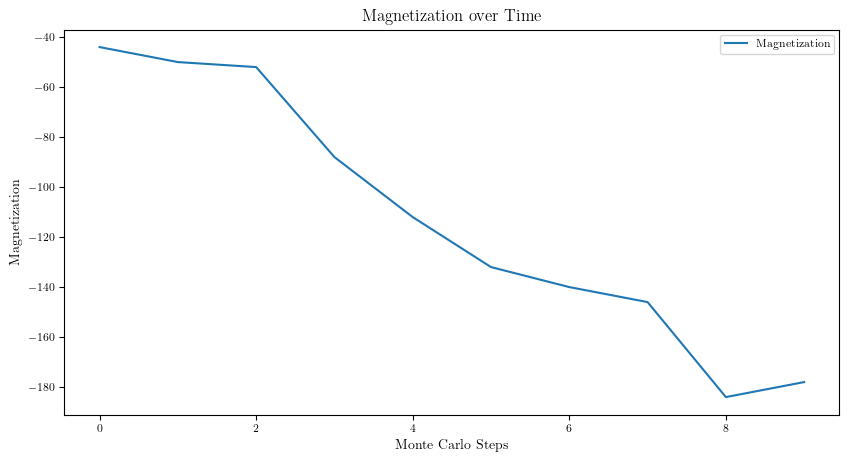

interactive(children=(IntSlider(value=0, description='t', max=9), Output()), _dom_classes=('widget-interact',)…

In [7]:
# Running the simulation
model = LatticeSpinMarketModel(side=side, dim=dim, params=parameters, T=T,  local_field_func=bornholdt_field, strategy_update_func=bornholdt_update_strategy, initial_strategy=strategies)
spin_series = model.run_simulation(steps=10, verbose=True)
model.plot_magnetization()
model.plot_lattice(interactive=True)

In [12]:
param_str = "long_sim_J{}_alpha{}_T{}_C{}".format(parameters['J'], parameters['alpha'], T, np.sum(strategies['C'] > 0))
pickle.dump(model, open(f"bornholdt_model_{param_str}.pkl", "wb"))

In [ ]:
param_str = "J{}_alpha{}_T{}_C{}".format(parameters['J'], parameters['alpha'], T, np.sum(strategies['C'] > 0))
pickle.dump(model, open(f"bornholdt_model_{param_str}.pkl", "wb"))

### Analysis of the results:

In [11]:
with open('bornholdt_constant_model_J1.0_alpha4.0_T1.5_C1024.pkl', 'rb') as f:
    model = pickle.load(f)

#### Constant strategy $C_i=1$

In [12]:
magnetization_series = [np.sum(spins) / len(spins) for spins in model.spin_series]

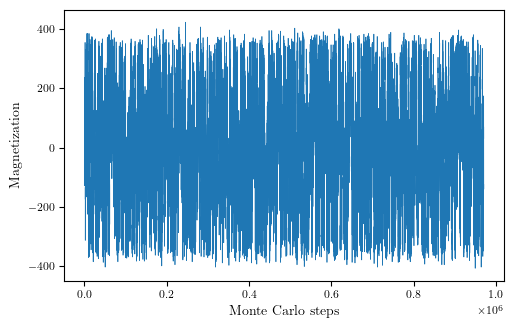

In [36]:
fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=0.9))
ax.plot(magnetization_series, linewidth=0.5)
plt.xlabel('Monte Carlo steps')
plt.ylabel('Magnetization')
plt.savefig(os.path.join(image_path, 'constant_c_magnetization.pdf'), bbox_inches='tight')
plt.show()

#### Starting distribution of the $C_i$

The minimum number of C_i = 1 for the three cases are:
 513 when starting with all C_i = -1,
 513 when starting with balanced C_i, and
 513 when starting with all C_i = +1
The maximum number of C_i = 1 for the three cases are:
 715 when starting with all C_i = -1,
 698 when starting with balanced C_i, and
 714 when starting with all C_i = +1


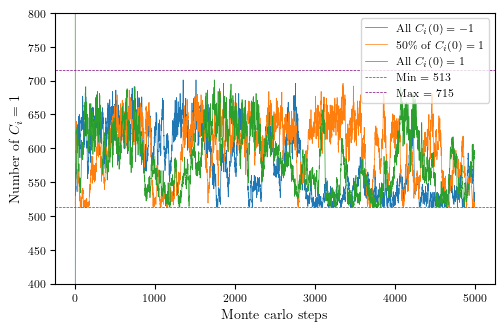

In [34]:
model_0 = pickle.load(open('bornholdt_model_J1.0_alpha4.0_T1.5_C0.pkl', "rb"))
model_516 = pickle.load(open('bornholdt_model_J1.0_alpha4.0_T1.5_C516.pkl', "rb"))
model_1024 = pickle.load(open('bornholdt_model_J1.0_alpha4.0_T1.5_C1024.pkl', "rb"))

ones_0 = [np.count_nonzero(strategy['C'] == 1) for strategy in model_0.strategy_list]
ones_516 = [np.count_nonzero(strategy['C'] == 1) for strategy in model_516.strategy_list]
ones_1024 = [np.count_nonzero(strategy['C'] == 1) for strategy in model_1024.strategy_list]

min_0 = np.min(ones_0[10:])
min_516 = np.min(ones_516[10:])
min_1024 = np.min(ones_1024[10:])
print(f"The minimum number of C_i = 1 for the three cases are:\n {min_0} when starting with all C_i = -1,\n {min_516} when starting with balanced C_i, and\n {min_1024} when starting with all C_i = +1")
minimum = min(min_0, min_516, min_1024)

max_0 = np.max(ones_0[10:])
max_516 = np.max(ones_516[10:])
max_1024 = np.max(ones_1024[10:])
print(f"The maximum number of C_i = 1 for the three cases are:\n {max_0} when starting with all C_i = -1,\n {max_516} when starting with balanced C_i, and\n {max_1024} when starting with all C_i = +1")
maximum = max(max_0, max_516, max_1024)

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=0.9))
plt.plot(ones_0[:5000], label=r'All $C_i(0) = -1$', linewidth=0.5)
plt.plot(ones_516[:5000], label=r'50\% of $C_i(0) = 1$', linewidth=0.5)
plt.plot(ones_1024[:5000], label=r'All $C_i(0) = 1$', linewidth=0.5)
plt.axhline(y=minimum, color='brown', linestyle='--', label=f"Min = {minimum}", linewidth=0.5)
plt.axhline(y=maximum, color='purple', linestyle='--', label=f"Max = {maximum}", linewidth=0.5)
plt.xlabel('Monte carlo steps')
plt.ylim(400, 800)
plt.ylabel('Number of $C_i = 1$')
plt.legend()
plt.savefig(os.path.join(image_path, 'c_values.pdf'), bbox_inches='tight')
plt.show()

In [8]:
with gzip.open('bornholdt_model_long_sim_J1.0_alpha4.0_T1.5_C502.gz', 'rb') as f:
    model = pickle.load(f)

In [9]:
magnetization_series = [np.sum(spins) for spins in model.spin_series]

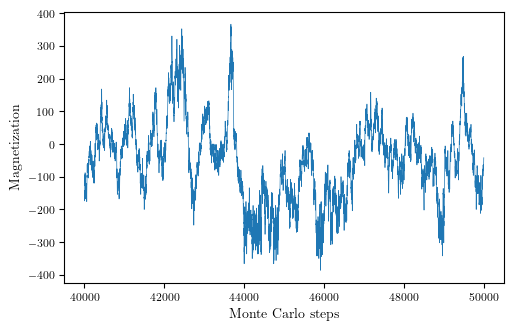

In [10]:
fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=0.9))
ax.plot(range(40000,50000), magnetization_series[40000:50000], linewidth=0.5)
plt.xlabel('Monte Carlo steps')
plt.ylabel('Magnetization')
plt.savefig(os.path.join(image_path, 'magnetization.pdf'), bbox_inches='tight')
plt.show()

#### Analysis of the returns:

In the paper, it is not clear how the logarithmic relative change $\text{ret}(t)=\ln(M(t))-\ln(M(t-1))$ is defined, considering that $M(t)$ can have negative values. We test shifting all its values up by its minimum possible value, and using its absolute value.

In [11]:
n = side**dim

magnetization_series_shifted = [np.sum(spin)/n + 1 for spin in model.spin_series]

log_returns = np.diff(np.log(magnetization_series_shifted))

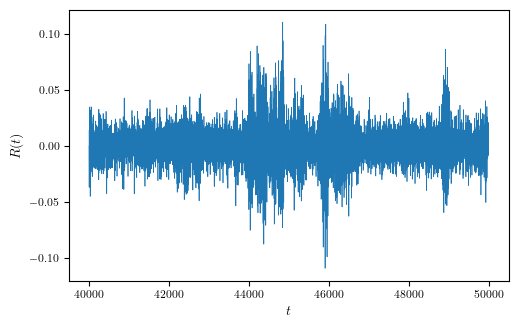

In [12]:
fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=0.9))
ax.plot(range(40000,50000), log_returns[40000:50000], linewidth=0.5)
plt.xlabel(r"$t$")
plt.ylabel(r"$R(t)$")
plt.show()

In [13]:
abs_magnetization_series = [np.abs(np.sum(spin))/n for spin in model.spin_series]

In [14]:
# we add a small epsilon to avoid taking the logarithm of 0
epsilon = 1e-3
abs_magnetization_series_shifted = np.array(abs_magnetization_series) + epsilon
log_returns = np.diff(np.log(abs_magnetization_series_shifted))

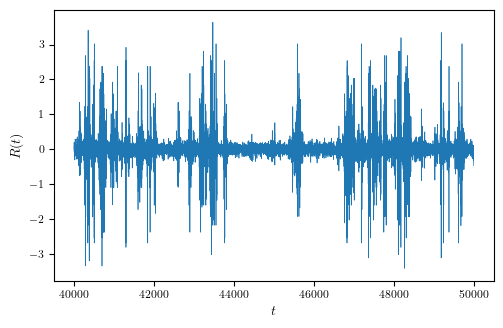

In [15]:
fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=0.9))
ax.plot(range(40000,50000), log_returns[40000:50000], linewidth=0.5)
plt.xlabel(r"$t$")
plt.ylabel(r"$R(t)$")
plt.savefig(os.path.join(image_path, 'returns.pdf'), bbox_inches='tight')
plt.show()

Qualitatively, the graph corresponding to the absolute value resembles the one in the paper more closely. We will use that one for now. Next, we plot the cumulative distribution of log returns.

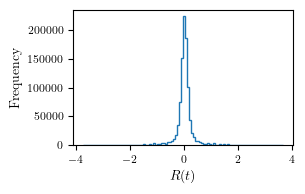

In [16]:
fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=0.45))
plt.hist(log_returns, bins=100, density=False, cumulative=False, histtype='step')
plt.xlabel(r"$R(t)$")
plt.ylabel("Frequency")
plt.savefig(os.path.join(image_path, 'distribution_returns.pdf'), bbox_inches='tight')
plt.show()

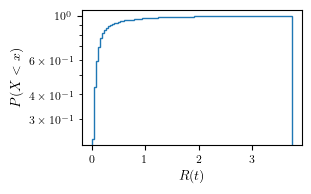

In [17]:
fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=0.45))
plt.hist(abs(log_returns), bins=100, density=True, cumulative=True, histtype='step')
plt.xlabel(r"$R(t)$")
plt.ylabel(r"$P(X<x)$")
plt.yscale('log')
plt.savefig(os.path.join(image_path, 'cumulative_distribution.pdf'), bbox_inches='tight')
plt.show()

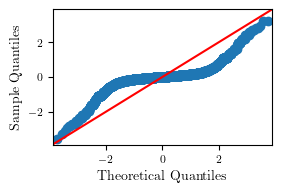

In [ ]:
# we plot the qq plot of the returns
fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=0.45))
sm.qqplot(np.random.choice(log_returns, size=10000, replace=False), line ='45', ax=ax) #sample 10000 to avoid having a heavy figure
plt.savefig(os.path.join(image_path, 'qqplot-returns.pdf'), bbox_inches='tight')
plt.show()

In [18]:
sw_test = stats.shapiro(log_returns)
print(f"Shapiro-Wilk test statistic: {sw_test.statistic}, p-value: {sw_test.pvalue}")

Shapiro-Wilk test statistic: 0.6921626126571194, p-value: 1.1440494551040125e-192


/Users/edoardoghirardo/miniconda/envs/thesis/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 969999.
  res = hypotest_fun_out(*samples, **kwds)


In [21]:
kurtosis = stats.kurtosis(log_returns, fisher=False, bias=False)
print(f"Kurtosis: {kurtosis}")

Kurtosis: 24.182177334374682


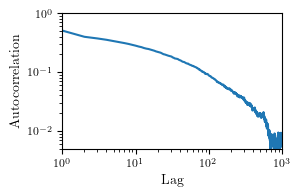

In [79]:
autocorr = sm.tsa.acf(abs(log_returns), nlags=np.shape(log_returns)[0] - 1)

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=0.45))
plt.plot(autocorr)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 1000)
plt.ylim(5e-3, 1)
plt.savefig(os.path.join(image_path, 'autocorrelation.pdf'), bbox_inches='tight')
plt.show()

In [80]:
# find indices of 0 values of magnetization series
indices = np.where(np.array(magnetization_series) == 100)[0]
indices

array([   228,    338,    348, ..., 969763, 969772, 969784], shape=(3303,))

In [81]:
def plot_lattice(model, t):
    model.plot_lattice(t=t)

interact(lambda t: plot_lattice(model, indices[t]), t=IntSlider(min=0, max=len(indices)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=3302), Output()), _dom_classes=('widget-interact…

<function __main__.<lambda>(t)>

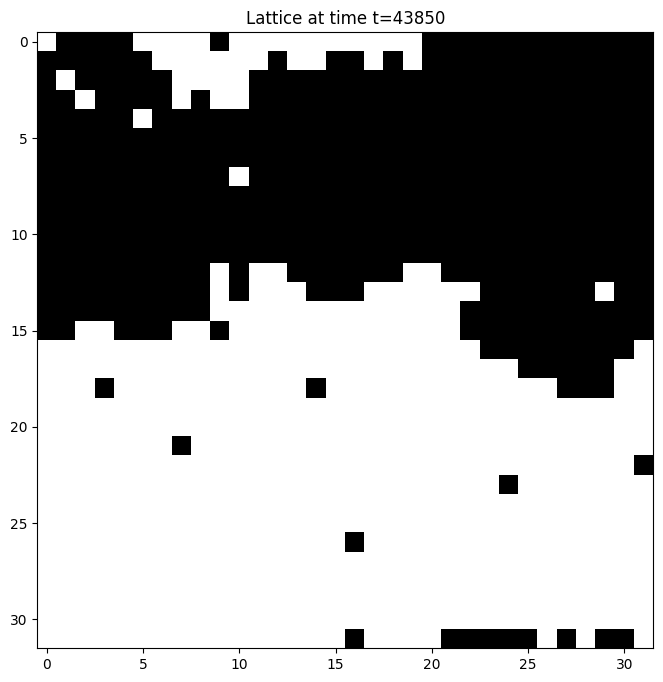

In [137]:
model.plot_lattice(t=43850)

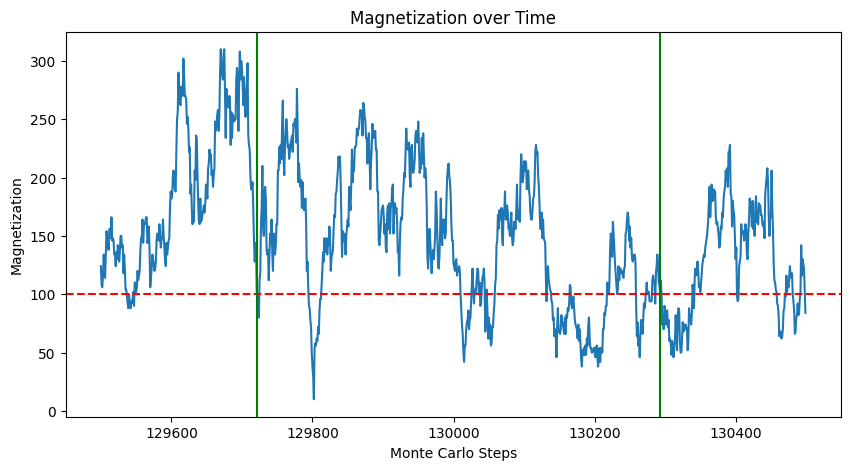

In [131]:
start = 129500
end = 130500

restricted_magnetization = [np.sum(spins) for spins in model.spin_series[start:end]]
plt.figure(figsize=(10, 5))
plt.plot(range(start,end),restricted_magnetization)
plt.xlabel("Monte Carlo Steps")
plt.ylabel("Magnetization")
plt.title("Magnetization over Time")
plt.axhline(100, color='red', linestyle='--')
plt.axvline(129722, color='green', linestyle='-')
plt.axvline(130293, color='green', linestyle='-')